In [76]:
import sys
import os

import pandas as pd
import numpy as np
from numpy import polyfit, poly1d, polyval

import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
pwd

'U:\\my_projs'

In [90]:
lsd_result_path = "U:/my_projs/g_output_PPT/lsd_test_result.csv"
edlines_result_path = "U:/my_projs/g_output_PPT/edlines_test_result.csv"
canny_result_path = "U:/my_projs/g_output_PPT/cannyPF_test_result.csv"
mcmlsd_result_path = "U:/my_projs/g_output_PPT/MCMLSD_test_result.csv"

htlcnn_result_path = "U:/my_projs/g_output_PPT/test_10-19_HTLCNN.csv"
fclip_result_path = "U:/my_projs/g_output_PPT/test_10-26_FClip_HG2_LB(truncated).csv"

df_lsd_original = pd.read_csv(lsd_result_path)
df_edlines_original = pd.read_csv(edlines_result_path)
df_canny_original = pd.read_csv(canny_result_path)
df_mcmlsd_original = pd.read_csv(mcmlsd_result_path)

df_htlcnn_original = pd.read_csv(htlcnn_result_path)
df_fclip_original = pd.read_csv(fclip_result_path)

In [91]:
def filter_ip_cols(df, method):
    df['time'] = df['runTime_cpp'] + df['runTime_matlab']
    df['left_pos_big'] = df[['left_pos1', 'left_pos2']].apply(max, axis=1)
    df['left_pos_small'] = df[['left_pos1', 'left_pos2']].apply(min, axis=1)
    df['right_pos_big'] = df[['right_pos1', 'right_pos2']].apply(max, axis=1)
    df['right_pos_small'] = df[['right_pos1', 'right_pos2']].apply(min, axis=1)
    
    df.drop(['runTime_cpp', 'runTime_matlab', 'left_window_start', 'left_pos1', 'left_pos2', 'left_num', 'left_len', \
             'right_window_start', 'right_pos1', 'right_pos2', 'right_num', 'right_len', \
            'metric_RMSE_polyfit', 'scale', 'angle_expect', 'angle_tolerance', 'windowWidth', 'windowStepSize', 'decision_criter', \
             'prior_excluded_middle_percent', 'is_labeled'], axis=1, inplace=True)
    

    rename = {
        'folderName': 'folder',
        'imgName': 'img',
        'left_border_label': 'left_label',
        'right_border_label': 'right_label',
        'metric_RMSE_vertical': 'RSE',
    } 
    df.rename(rename, axis=1, inplace=True)
    
    df['method'] = method
    df['middle_MAE'] = np.abs(((df['left_pos_small']+df['right_pos_big'])/2) - ((df['left_label']+df['right_label'])/2))
    
    return df

In [92]:
df_lsd = filter_ip_cols(df_lsd_original, 'LSD')
df_edlines = filter_ip_cols(df_edlines_original, 'EDLines')
df_canny = filter_ip_cols(df_canny_original, 'CannyPF')
df_mcmlsd = filter_ip_cols(df_mcmlsd_original, 'MCMLSD')

In [93]:
df_lsd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1508 entries, 0 to 1507
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   folder           1508 non-null   object 
 1   img              1508 non-null   object 
 2   left_label       1508 non-null   int64  
 3   right_label      1508 non-null   int64  
 4   RSE              1508 non-null   float64
 5   time             1508 non-null   float64
 6   left_pos_big     1508 non-null   int64  
 7   left_pos_small   1508 non-null   int64  
 8   right_pos_big    1508 non-null   int64  
 9   right_pos_small  1508 non-null   int64  
 10  method           1508 non-null   object 
 11  middle_MAE       1508 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 141.5+ KB


In [94]:
def parser_str_to_tuple(tuple_in_str):
    x, y = tuple_in_str.split(',')
    return (float(x[1:]), float(y[:-1]))

def map_junc_to_pos(x1, y1, x2, y2):
    y = np.array([x1, x2])
    x = np.array([y1, y2])
    
    coeff = polyfit(x, y, 1)
#     pos1 = poly1d(coeff, 0)  # equation of line
#     pos2 = poly1d(coeff, 3087)
    pos1 = polyval(coeff, 0)
    pos2 = polyval(coeff, 0)
    
    return pos1, pos2

In [95]:
def filter_dl_cols(df, method):
    df['x1'] = df['left_junc0'].apply(parser_str_to_tuple).apply(lambda x: x[0])
    df['y1'] = df['left_junc0'].apply(parser_str_to_tuple).apply(lambda x: x[1])

    df['x2'] = df['left_junc1'].apply(parser_str_to_tuple).apply(lambda x: x[0])
    df['y2'] = df['left_junc1'].apply(parser_str_to_tuple).apply(lambda x: x[1])
    
    df['left_pos1'] = df.apply(lambda x: map_junc_to_pos(x.x1, x.y1, x.x2, x.y2), axis=1).apply(lambda x: x[0])
    df['left_pos2'] = df.apply(lambda x: map_junc_to_pos(x.x1, x.y1, x.x2, x.y2), axis=1).apply(lambda x: x[1])
    
    df['left_pos_big'] = df[['left_pos1', 'left_pos2']].apply(max, axis=1)
    df['left_pos_small'] = df[['left_pos1', 'left_pos2']].apply(min, axis=1)
    df.drop(['x1', 'y1', 'x2', 'y2', 'left_pos1', 'left_pos2'], axis=1, inplace=True)
    
    
    df['x1'] = df['right_junc0'].apply(parser_str_to_tuple).apply(lambda x: x[0])
    df['y1'] = df['right_junc0'].apply(parser_str_to_tuple).apply(lambda x: x[1])

    df['x2'] = df['right_junc1'].apply(parser_str_to_tuple).apply(lambda x: x[0])
    df['y2'] = df['right_junc1'].apply(parser_str_to_tuple).apply(lambda x: x[1])
    
    df['right_pos1'] = df.apply(lambda x: map_junc_to_pos(x.x1, x.y1, x.x2, x.y2), axis=1).apply(lambda x: x[0])
    df['right_pos2'] = df.apply(lambda x: map_junc_to_pos(x.x1, x.y1, x.x2, x.y2), axis=1).apply(lambda x: x[1])
    
    df['right_pos_big'] = df[['right_pos1', 'right_pos2']].apply(max, axis=1)
    df['right_pos_small'] = df[['right_pos1', 'right_pos2']].apply(min, axis=1)
    df.drop(['x1', 'y1', 'x2', 'y2', 'right_pos1', 'right_pos2'], axis=1, inplace=True)
    
    
    df.drop(['Unnamed: 0', 'left_junc0', 'left_junc1', 'right_junc0', 'right_junc1'], axis=1, inplace=True)
    
    rename = {'RMSE': 'RSE'} 
    df.rename(rename, axis=1, inplace=True)
    
    df['method'] = method
    df['middle_MAE'] = np.abs(((df['left_pos_small']+df['right_pos_big'])/2) - ((df['left_label']+df['right_label'])/2))
    
    return df

In [96]:
df_htlcnn = filter_dl_cols(df_htlcnn_original, 'HT-LCNN')
df_fclip  = filter_dl_cols(df_fclip_original, 'F-Clip')

In [97]:
df_htlcnn.head(2)

,folder,img,left_label,right_label,RSE,time,left_pos_big,left_pos_small,right_pos_big,right_pos_small,method,middle_MAE
0,2022-04-28_13-09-34,66101184000.png,718,2177,19.253608,2.59375,699.62523,699.62523,2171.250000,2171.250000,HT-LCNN,12.062385
1,2022-04-28_13-09-34,38948688000.png,730,2181,31.901360,0.46875,699.62523,699.62523,2171.250185,2171.250185,HT-LCNN,20.062292


In [98]:
df_htlcnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1508 entries, 0 to 1507
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   folder           1508 non-null   object 
 1   img              1508 non-null   object 
 2   left_label       1508 non-null   int64  
 3   right_label      1508 non-null   int64  
 4   RSE              1508 non-null   float64
 5   time             1508 non-null   float64
 6   left_pos_big     1508 non-null   float64
 7   left_pos_small   1508 non-null   float64
 8   right_pos_big    1508 non-null   float64
 9   right_pos_small  1508 non-null   float64
 10  method           1508 non-null   object 
 11  middle_MAE       1508 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 141.5+ KB


In [105]:
df_fclip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1694 entries, 0 to 1693
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   folder           1694 non-null   object 
 1   img              1694 non-null   object 
 2   left_label       1694 non-null   int64  
 3   right_label      1694 non-null   int64  
 4   RSE              1694 non-null   float64
 5   time             1694 non-null   float64
 6   left_pos_big     1694 non-null   float64
 7   left_pos_small   1694 non-null   float64
 8   right_pos_big    1694 non-null   float64
 9   right_pos_small  1694 non-null   float64
 10  method           1694 non-null   object 
 11  middle_MAE       1694 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 158.9+ KB


In [111]:
df_fclip = df_fclip[(df_fclip.folder.isin(df_lsd.folder)) & (df_fclip.img.isin(df_lsd.img))]  # unhashable type: 'Series'

In [112]:
df = pd.concat([df_lsd, df_edlines, df_canny, df_mcmlsd, df_htlcnn, df_fclip], axis=0, ignore_index=True)

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   folder           9093 non-null   object 
 1   img              9093 non-null   object 
 2   left_label       9093 non-null   int64  
 3   right_label      9093 non-null   int64  
 4   RSE              9093 non-null   float64
 5   time             9093 non-null   float64
 6   left_pos_big     9093 non-null   float64
 7   left_pos_small   9093 non-null   float64
 8   right_pos_big    9093 non-null   float64
 9   right_pos_small  9093 non-null   float64
 10  method           9093 non-null   object 
 11  middle_MAE       9093 non-null   float64
 12  img_all          1553 non-null   object 
dtypes: float64(7), int64(2), object(4)
memory usage: 923.6+ KB


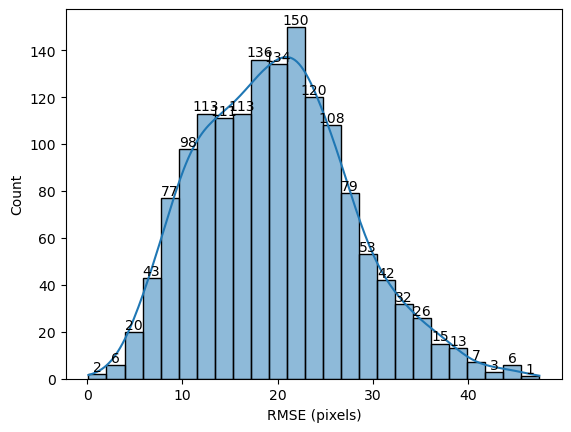

In [6]:
h = sns.histplot(data=df, x='RMSE',kde=True)
labels = [str(round(v)) if v else '' for v in h.containers[0].datavalues]
h.bar_label(h.containers[0], labels=labels)  # plt.bar_label(bar, label_type='edge')
h.set(xlabel='RMSE (pixels)')

plt.show()
fig = h.get_figure()
fig.savefig('U:/my_projs/g_output_DL/HT-HAWP_test_hist of RMSE.png')

In [7]:
df.shape[0]

1508

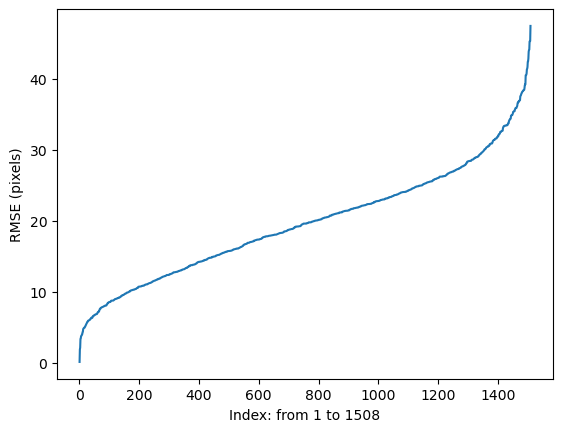

In [8]:
df_ascend = df.sort_values(by=['RMSE'], axis=0)

l = sns.lineplot(data=df_ascend, x=list(range(1,df.shape[0]+1)), y='RMSE')
l.set(xlabel=f'Index: from 1 to {df.shape[0]}')
l.set(ylabel='RMSE (pixels)')
plt.savefig('U:/my_projs/g_output_DL/HT-HAWP test_ordered plot of RMSE.png')

In [9]:
df.time.mean()  # seconds

0.5831606432360743

In [10]:
df.RMSE.mean() # pixels

19.772952278469475

In [11]:
# select the result according to the RMSE value
df_sub_0_20 = df[df.RMSE < 20]  # total number: 785
df_sub_20_30 =  df[(df.RMSE >= 20) & (df.RMSE < 30)] # totalnumber: 568
df_sub_30_40 =  df[(df.RMSE >= 30) & (df.RMSE < 40)] # totalnumber: 138
df_sub_40_50 =  df[(df.RMSE >= 40) & (df.RMSE < 50)] # totalnumber: 17
df_sub_over_50 =  df[(df.RMSE >50)] # total number: 0
print(f'Total number are: {df_sub_0_20.shape[0]}, {df_sub_20_30.shape[0]}, {df_sub_30_40.shape[0]}, {df_sub_40_50.shape[0]}, {df_sub_over_50.shape[0]}')

Total number are: 785, 568, 138, 17, 0


In [12]:
def parser_str_to_tuple(tuple_in_str):
    x, y = tuple_in_str.split(',')
    return (float(x[1:]), float(y[:-1]))

In [13]:
juncs = []
for record_tuple in df.itertuples():
    _, _, folder, img_png, l_label, ljunc0, ljunc1, r_label, rjunc0, rjunc1, rmse, time = record_tuple
    ljunc0, ljunc1, rjunc0, rjunc1 = map(parser_str_to_tuple, (ljunc0, ljunc1, rjunc0, rjunc1))
    record = {
        "ljunc0_x": ljunc0[0],
        "ljunc0_y": ljunc0[1],
        "ljunc1_x": ljunc1[0],
        "ljunc1_y": ljunc1[1],
        
        "rjunc0_x": rjunc0[0],
        "rjunc0_y": rjunc0[1],
        "rjunc1_x": rjunc1[0],
        "rjunc1_y": rjunc1[1],
    }
    juncs.append(record)

In [14]:
df_junc = pd.DataFrame(juncs)

In [15]:
df_junc

,ljunc0_x,ljunc0_y,ljunc1_x,ljunc1_y,rjunc0_x,rjunc0_y,rjunc1_x,rjunc1_y
0,699.625046,2051.528320,699.625230,3.653469,2171.250,11.337950,2171.250000,2059.212891
1,699.625046,2051.528320,699.625230,3.653475,2171.250,2059.212891,2171.250184,11.337964
2,675.500046,2051.402344,675.500092,3.527417,2123.000,2058.960938,2123.000000,11.085997
3,699.625046,2051.528320,699.625230,3.653476,2171.250,2059.212891,2171.250184,11.337960
4,675.500092,2051.402467,699.625230,3.653478,2171.250,2059.212891,2171.250184,11.337965
...,...,...,...,...,...,...,...,...
1503,217.125069,2049.008789,217.125207,1.133927,2677.875,2061.858398,2677.875184,13.983477
1504,217.125069,2049.008789,217.125184,1.133917,2702.000,14.109427,2702.000000,2061.984375
1505,217.125115,2049.008912,217.125253,1.133955,2726.125,2062.110352,2726.125184,14.235417
1506,217.125092,2049.008789,217.125207,1.133924,2702.000,2061.984375,2702.000184,14.109437


<AxesSubplot:xlabel='rjunc1_x', ylabel='rjunc1_y'>

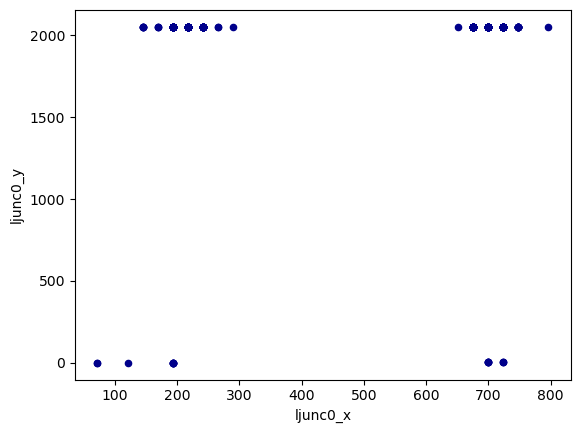

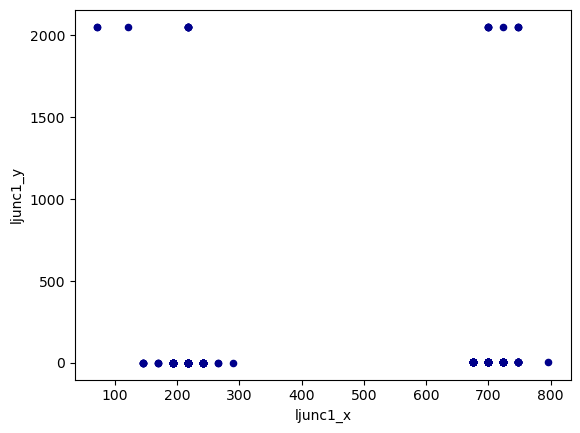

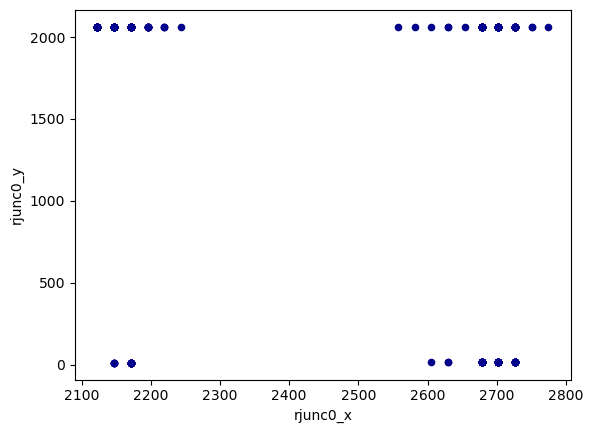

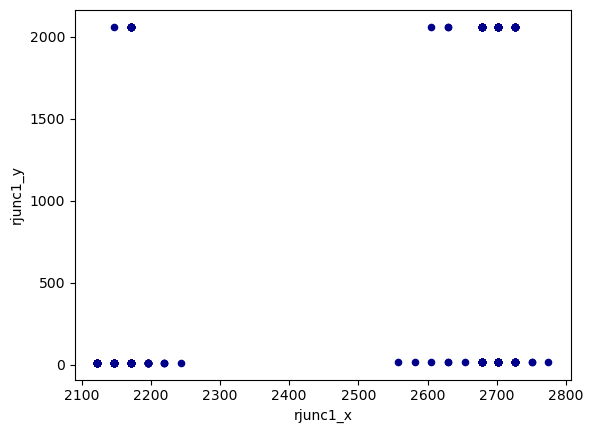

In [16]:
df_junc.plot.scatter(x='ljunc0_x', y='ljunc0_y', c='DarkBlue')
df_junc.plot.scatter(x='ljunc1_x', y='ljunc1_y', c='DarkBlue')

df_junc.plot.scatter(x='rjunc0_x', y='rjunc0_y', c='DarkBlue')
df_junc.plot.scatter(x='rjunc1_x', y='rjunc1_y', c='DarkBlue')